# Plotting separate PTE terms for all simulations 

Ting-Chen Chen (ting-chen.chen@kit.edu) 

In [1]:
dt = 6
data_res  = '1x1latlon'
if   dt == 1:
     data_dt = '1hrly'
elif dt == 6:
     data_dt = '6hrly'
        
p2level = 50

res='2km'

exp='channel_'+res+'_0006'

In [2]:
#####################################################
# cyclone specific data
#####################################################
# channel_Xkm_0001: control simulations
# channel_Xkm_0002: +4K, qv consistent with T
# channel_Xkm_0003: +4k, qv from control
# channel_Xkm_0004: +temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0005: +tropical temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0006: +polar temperature anomaly from MPI-ESM1-2-LR far future

# Note that the  2-km experiments contain outputs every 6 hrs
# Note that the 80-km experiments contain outputs every 1 hrs


expname = {
      1: 'CTL',    
      2: 'T+4K',
      3: 'T+4K_RH-',
      4: 'T+anom',
      5: 'T+TRanom_TR',
      6: 'T+POanom'
         }

exp80 = { 
      1:'channel_80km_0001',
      2:'channel_80km_0002',
      3:'channel_80km_0003',
      4:'channel_80km_0004',
      5:'channel_80km_0005',
      6:'channel_80km_0006',
      }

exp2 = { 
      1:'channel_2km_0001',
      2:'channel_2km_0002',
      3:'channel_2km_0003',
      4:'channel_2km_0004',
      5:'channel_2km_0005',
      6:'channel_2km_0006',
      }



In [3]:
import numba
from numba import njit
import math
import psutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime  
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings("ignore")
from platform import python_version

In [4]:
# Some functions: to be used for the calculations in the SPTE script

def get_es(t): 
    '''
    # t is the temperature in Kelvin
    # function that calculates the saturation vapour pressure
    '''
    es  = 6.112 * np.exp((17.67*(t-273.15))/((t-273.15)+243.5))
    return es

def get_e(t, rh):
    '''
    # rh is the relative_humidity & es is the saturation_vapour_pressure
    # function that calculates the vapour pressure
    '''
    e   = rh*get_es(t)/100
    return e

def get_shu(rh, t, p):
    '''
    # function that calculates the specific humidity
    # pressure must be given in hPa
    '''
    shu = (0.622 * get_e(t,rh))/(p-(0.378*get_e(t,rh)))
    return shu
    
def get_mix(e,p,t,rh):
    '''
    # function that calculates the mixing ratio
    # e : vapour pressure
    # p : pressure in Pa
    # t : temperature
    # rh: relative humidity
    '''
    mix = (0.622 * get_e(t,rh)) / ((p/100)-get_e(t,rh))    
    return mix
    
def get_adia_lr(t,rh,p):
    '''
    # function that calculates the dry/moist adiabatic lapse rate
    # t : temperature
    # rh: relative humidity
    '''
    if rh < 95.:
        adia = g/C_p
    else:
        e_h   = get_e(t,rh)
        mix_h = get_mix(e_h, p, t, rh)
        adia  = g * ((1 + ((LV * mix_h) / (R * t))) / (C_p + ((LV**2 * mix_h * 0.622) / (R * t**2))))
    return adia

def get_rhm_sfc(t2m ,td2m):
    '''
    # function that calculates the relative humidity in the sfc
    '''
    rhm_sfc = 100 * (get_es(td2m)/get_es(t2m))
    return rhm_sfc

def get_theta(t, p):
    '''
    # function that calculates the potential temperature for given Temperature(t in Kelvin) and pressure,
    '''
    theta = t * ( 1.e5 / p) ** 0.286
    return theta

def get_T_v(t, shu):
    '''
    # function that calculates the virtual temperature for given Temperature(t in Kelvin),
    # Relative Humidity(rh [0-100]) & Pressure(p in hPa)
    # we calculate the specific humidity
    '''
    T_v = t * (1 + 0.608 * shu)
    return T_v

@njit
def get_T_adv(T, u, v, lat, lon, ntimes, nlevs, nlats, nlons):
    '''
    # function that calculates the Horizontal Temperature Advection (T_adv)
    # we use as imput the u and v wind components with shape (ntimes, nlevs, nlats, nlons)
    # and the temperature gradient components with shape (ntimes, nlevs, nlats, nlons)
    '''
    deg2rad = np.pi/180.0
    
    T_adv = np.full((ntimes,nlevs,nlats,nlons),np.nan,dtype=np.float64)
    
    for lati in range(nlats):
        for loni in range(nlons):
            
            latiU = min (lati+1, nlats-1)
            latiL = max (lati-1, 0)
            #loniU = min (loni+1, nlons-1)
            #loniL = max (loni-1, 0)
            loniU = loni+1
            loniL = loni-1
            londis = lon[loniU]-lon[loniL]
            if loni == nlons-1:
                loniU = 0
                londis = 2.
            if loni == 0:    
                londis = 2.
                
            # Zonal distance between two points at the same latitude 
            #------------------------------------------------------------------------------------------------------------------------------
            # Based on an ellipsoid (e.g. WGS84):
            # ps., more realistic for the Earth but not necessary the assumption used in the numerical NWP/climate models!
            #
            # zon = u[:,:,lati,loni]/(rearth*np.cos(lat[lati]*deg2rad)) * (T[:,:,lati,loniU]-T[:,:,lati,loniL])/(deg2rad*(lon[loniU]-lon[loniL]))
            #------------------------------------------------------------------------------------------------------------------------------
            #------------------------------------------------------------------------------------------------------------------------------
            # Based on a sphere with a constant radius:
            # ps., likely used in ICON-NWP models!
            # 
            zon = u[:,:,lati,loni]/rearth * (T[:,:,lati,loniU]-T[:,:,lati,loniL])/(deg2rad*(londis))
            mer = v[:,:,lati,loni]/rearth * (T[:,:,latiU,loni]-T[:,:,latiL,loni])/(deg2rad*(lat[latiU]-lat[latiL]))   
            T_adv[:,:,lati,loni] = -1* (zon + mer)
            
    return T_adv
       
def get_ro_sfc(t_sfc, p_sfc):
    '''
    # function that calculates the density in the surface for given surface pressure
    # and temperature (conventionally we can use temprature at 2 m)
    # Pressure    in Pa
    # Temperature in K
    '''
    ro   = np.full((ntimes,nlats,nlons),np.nan,dtype=float)
    ro   = p_sfc / (t_sfc * R)    
    return ro  


def get_ro_lpl(tv, p, ntimes, nlats, nlons, nlevs):
    '''
    # function that calculates the 4D density 
    '''
    
    ro_lpl = np.full(tv.shape,np.nan,dtype=np.float64) 
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                for il in range (nlevs):
                    ro_lpl[ti,la,lo]   = p[ti,il,la,lo] / (tv[ti,il,la,lo] * R)
    return ro_lpl

@njit
def get_dT_dp(t, p, ntimes, nlevs, nlats, nlons):
    '''
    # function that calculates the vertical temperature gradient
    '''
    dT_dp = np.full((ntimes,nlevs,nlats,nlons),np.nan,dtype=np.float64)
    #dT_dp = np.full((ntimes,nlevs+1,nlats,nlons), np.nan,dtype=float)
    for ti in range(ntimes):
        for le in range(nlevs):
            leU = min (le+1, nlevs-1)
            leL = max (le-1, 0)
            dT_dp[ti,le,:,:] = (t[ti,leU,:,:]-t[ti,leL,:,:]) / (p[ti,leU,:,:]-p[ti,leL,:,:]) 
     
    return dT_dp

def get_dT_dz(dT_dp, ro):
    '''
    # function that calculates the tempertature advetion due to vertical motions
    '''
    dT_dz = dT_dp * ( -ro ) * g 
    
    return dT_dz
           
def get_T_vmt_dry(T_v, dTv_dp, omega, level):
    '''
    # function that calculates the tempertature advetion due to vertical motions
    '''
    T_vmt = omega * ( (R * T_v ) / ( C_p * level) - dTv_dp) 
    
    return T_vmt  

@njit
def get_p_levs(level,ntimes,nlevs,nlats,nlons):
    
    p_levs = np.full((ntimes,nlevs,nlats,nlons), np.nan , dtype=np.float64)
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                p_levs[ti,:,la,lo] = level

    return p_levs

@njit
def logp_integral(var_datanan0,logp1D,ro,ntimes,nlats,nlons):
    
    I_var  = np.full((ntimes,nlats,nlons), np.nan, dtype=np.float64)
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                I_var[ti,la,lo] = np.trapz(var_datanan0[ti,:,la,lo],x=logp1D)*-1 *dt * h_in_sec * ro[ti,la,lo] * R
    return I_var

@njit
def logp_integral_simple(var_datanan0,logp1D,ro,ntimes,nlats,nlons):
    
    I_var  = np.full((ntimes,nlats,nlons), np.nan, dtype=np.float64)
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                I_var[ti,la,lo] = np.trapz(var_datanan0[ti,:,la,lo],x=logp1D)
    return I_var


def get_pv(vor,dT_dp):

    PV = (vor+f) * dT_dp * -g
                
    return PV


In [5]:


# Path on Levante for the input data
# Interpolated up to 10hPa
datapath='/work/bb1152/Module_A/A6_CyclEx/sim_data/production/'


#----2D atmospheric variables----
ipath2d   = datapath+exp+"/remapped_atm2d_latlon/"
ifile2d   = "icon-atm2d_ML_reg_con_202101*.nc"

print(ipath2d+ifile2d)

#----3D atmospheric variables----
ipath3d   = datapath+exp+"/remapped_atm3d_latlon/"
ifile3d   = "icon-atm3d_PL_reg_con_202101*.nc"

print(ipath3d+ifile3d)



/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0006/remapped_atm2d_latlon/icon-atm2d_ML_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0006/remapped_atm3d_latlon/icon-atm3d_PL_reg_con_202101*.nc


In [6]:
ds2d     = xr.open_mfdataset(ipath2d+ifile2d)

In [7]:
ds3d     = xr.open_mfdataset(ipath3d+ifile3d)

In [8]:
# select required variables

ds3d = ds3d[['temp',
            'qv',
            'u',
            'v',
            #'w',
            'omega',
            'geopot',
            'vor']]


# pres_sfc: surface pressure [Pa]
# pres_msl: mea-sea-level pressure [Pa]
# tot_prec: total precipitation [kg m-2]
# qhfl_s: surface moisture flux [Kg m-2 s-1]
# t_2m: temperature in 2m [K]
# qv_2m: specific water vapor content in 2m 
ds2d = ds2d[['pres_sfc',
             'pres_msl',
             'tot_prec',
             'qhfl_s',
             't_2m',
             'qv_2m']]   

ds = xr.merge([ds2d,ds3d])

In [9]:
# Select timesteps every 6 hours. 
# NOT REQUIRED FOR 2KM SIMS AS OF NOW BECAUSE DATA IS ONLY AVAILABLE EVERY 6 HRS!


def createList(r1, r2, r3):
    return list(range(r1, r2+1, r3))

# Note that I name the first day (time index starting from 0) as day 1 instead of day 0 

if res == '80km': 
    
    if data_dt =='6hrly':
    
        ds = ds.isel(time=createList(36,216+1,6))  # day 2.5- 9, every 6 hr (starting from t=0)
        
    elif data_dt =='1hrly':
    
        ds = ds.isel(time=slice(36,216+1))        # day 2.5- 9, every 1 hr

else :  #2-km experiments
    
    ds = ds.isel(time=slice(6,36+1))              # day 2.5-9, every 6 hr 

In [10]:
# set relative time-axis

ds["time"] = ds.time - 20210101

In [11]:
# Select subdomain without meridional boundaries

latmin = 15 # idea: could use the minimum domain required in terms of lat here
latmax = 80

# Do not cut the west-east sides of the domains as the cyclone
# moves periodically in the zonal direction! 
ds = ds.sel(lat=slice(latmin,latmax))
ds

<xarray.Dataset>
Dimensions:   (time: 31, lat: 65, lon: 51, height_2: 1, plev_3: 100)
Coordinates:
  * time      (time) float64 1.5 1.75 2.0 2.25 2.5 ... 8.0 8.25 8.5 8.75 9.0
  * lon       (lon) float64 12.5 13.5 14.5 15.5 16.5 ... 59.5 60.5 61.5 62.5
  * lat       (lat) float64 15.5 16.5 17.5 18.5 19.5 ... 76.5 77.5 78.5 79.5
  * height_2  (height_2) float64 2.0
  * plev_3    (plev_3) float64 1e+03 2e+03 3e+03 4e+03 ... 9.8e+04 9.9e+04 1e+05
Data variables: (12/13)
    pres_sfc  (time, lat, lon) float32 dask.array<chunksize=(1, 65, 51), meta=np.ndarray>
    pres_msl  (time, lat, lon) float32 dask.array<chunksize=(1, 65, 51), meta=np.ndarray>
    tot_prec  (time, lat, lon) float32 dask.array<chunksize=(1, 65, 51), meta=np.ndarray>
    qhfl_s    (time, lat, lon) float32 dask.array<chunksize=(1, 65, 51), meta=np.ndarray>
    t_2m      (time, height_2, lat, lon) float32 dask.array<chunksize=(1, 1, 65, 51), meta=np.ndarray>
    qv_2m     (time, height_2, lat, lon) float32 dask.array<chunksize=(1, 1, 65, 51), meta=np.ndarray>
    ...        ...
    qv        (time, plev_3, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    u         (time, plev_3, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    v         (time, plev_3, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    omega     (time, plev_3, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    geopot    (time, plev_3, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    vor       (time, plev_3, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    Conventions:               CF-1.6
    source:                    @
    institution:               Max Planck Institute for Meteorology/Deutscher...
    title:                     ICON simulation
    history:                   Thu Jul 14 23:02:03 2022: cdo -P 32 remapcon,/...
    references:                see MPIM/DWD publications
    comment:                   Nicole Knopf (b380906) on l40495 (Linux 4.18.0...
    cdo_openmp_thread_number:  32
    CDO:                       Climate Data Operators version 2.0.5 (https://...

In [12]:
# Read the data from model outputs

lons         = ds.variables['lon'][:].to_numpy()
lats         = ds.variables['lat'][:].to_numpy()
time         = ds.variables['time'][:].to_numpy()
level        = ds.variables['plev_3'][:].to_numpy()              # pressure [Pa]
t            = ds.variables['temp'][:].to_numpy()                # temperature [K]
shu          = ds.variables['qv'][:].to_numpy()                  # specific humidity [kg/kg]
u            = ds.variables['u'][:].to_numpy()                   # u wind [m/s]
v            = ds.variables['v'][:].to_numpy()                   # v wind [m/s]
#w            = ds.variables['w'][:].to_numpy()                  # vertical velocity [m/s];not required for PTE. Just for illustration.
                                                                
omega        = ds.variables['omega'][:].to_numpy()               # vertical velocity [Pa/s]
vor          = ds.variables['vor'][:].to_numpy()                 # relative vorticity
geopot       = ds.variables['geopot'][:].to_numpy()                 
p_sfc        = ds.variables['pres_sfc'][:].to_numpy()
t_2m         = ds.variables['t_2m'][:,0,:,:].to_numpy()
shu_2m       = ds.variables['qv_2m'][:,0,:,:].to_numpy()
mslp         = ds.variables['pres_msl'][:].to_numpy()
tot_precip   = ds.variables['tot_prec'][:].to_numpy()
evapor_per_s = ds.variables['qhfl_s'][:].to_numpy()              # surface moisture flux [Kg m-2 s-1]
    
print (p_sfc.shape)
print (time.shape,lats.shape,lons.shape)
print (omega.shape)
print (p_sfc.shape)

(31, 65, 51)
(31,) (65,) (51,)
(31, 100, 65, 51)
(31, 65, 51)


In [13]:
# Dimensions of time-lon-lat-plvl and time interval
ntimes    = len(time)
nlevs     = len(level)
nlons     = len(lons)
nlats     = len(lats)
print('ntimes=',ntimes)
print('nlevs=',nlevs)
print('nlats=',nlats)
#print('level (Pa)=',level)
#print('temperature profile at (lon0, lat0)=', t[0,:,0,0])
p_levs = get_p_levs(level,ntimes,nlevs,nlats,nlons)

print (p_levs.shape)
print (lons.shape)
print (u.shape)
print('pressure at (lon0, lat0)=', p_levs[0,nlevs-1,0,0])
print('p_levs were set at: ', datetime.datetime.now().time())

ntimes= 31
nlevs= 100
nlats= 65
(31, 100, 65, 51)
(51,)
(31, 100, 65, 51)
pressure at (lon0, lat0)= 100000.0
p_levs were set at:  12:48:34.158987


In [14]:
# Some constant values
rearth   = 6.356766E+06       # earth's radius
R        = 287.04             # gas constant
C_p      = 1005.7             # specific heat capacity
g        = 9.81               # gravitational acceleration
LV       = 2.501E+06          # latent heat of vaporization at 0C
f        = 1.0E-04            # Coriolis parameter

In [15]:
# Derive other variables that are not directly output from the model:
theta = get_theta(t,p_levs)
dthetadp  = get_dT_dp(theta, p_levs, ntimes, nlevs, nlats, nlons)
pv    = get_pv(vor,dthetadp)
T_v     = get_T_v(t,shu)
print(pv.shape)
print(pv[2,50,2,2])

pv_select=pv[:,19:40,:,:]
print(pv_select.shape)

(31, 100, 65, 51)
6.02253112844805e-07
(31, 21, 65, 51)


In [16]:
print(p_levs[0,69,0,0]*0.01)   #lev=nlevs-1 surface 
print(p_levs[0,89,0,0]*0.01)

print(p_levs[0,19,0,0]*0.01)   #lev=nlevs-1 surface 
print(p_levs[0,39,0,0]*0.01)
#pv_avg = np.full((ntimes,nlats,nlons), np.nan, dtype=float)

pv_avg = np.mean(pv_select, axis=1)
    
print(pv_avg.shape)
print(pv_avg[2,2,2])

700.0
900.0
200.0
400.0
(31, 65, 51)
1.1821924883313116e-06


In [17]:
#####################################################
# Read in track data from file
#####################################################
#Cyclone Track
path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

df_track = pd.read_csv(path_track+'Track_for_'+exp+'_'+str(dt)+'hrly_1x1latlon.csv')

# get timesteps from map
#tmin = time.min()
#tmax = time.max()

# select timesteps from track
#df_track = df_track.loc[(df_track['time']>=tmin) & (df_track['time']<=tmax)]

# determine timesteps of track
ntrack = len(df_track['lat'])

track_dur  = df_track['time']
track_lon  = df_track['lon']
track_lat  = df_track['lat']
    
df_track


Unnamed: 0  time         pmin   lon   lat
0            0  0.00  1001.004700  50.5  23.5
1            1  0.25   998.373047  61.5  23.5
2            2  0.50   998.121826  19.5  43.5
3            3  0.75   997.513733  31.5  28.5
4            4  1.00   999.711426  25.5  44.5
5            5  1.25   998.156067  24.5  43.5
6            6  1.50   998.357910  28.5  44.5
7            7  1.75   998.299683  37.5  42.5
8            8  2.00   997.672424  40.5  43.5
9            9  2.25   996.791870  45.5  42.5
10          10  2.50   995.451721  45.5  44.5
11          11  2.75   993.176392  49.5  44.5
12          12  3.00   992.472473  53.5  46.5
13          13  3.25   991.768677  56.5  46.5
14          14  3.50   987.364929  61.5  43.5
15          15  3.75   979.655151  16.5  43.5
16          16  4.00   973.292236  18.5  45.5
17          17  4.25   970.220764  20.5  46.5
18          18  4.50   966.458496  22.5  47.5
19          19  4.75   963.531555  24.5  48.5
20          20  5.00   962.853760  25.5  48.5
21          21  5.25   964.222473  27.5  47.5
22          22  5.50   967.600342  30.5  46.5
23          23  5.75   969.177979  41.5  50.5
24          24  6.00   967.899902  43.5  50.5
25          25  6.25   966.300720  46.5  51.5
26          26  6.50   958.802185  58.5  50.5
27          27  6.75   950.869080  59.5  51.5
28          28  7.00   945.676147  60.5  52.5
29          29  7.25   946.446228  61.5  52.5
30          30  7.50   952.393982  13.5  51.5
31          31  7.75   951.814087  19.5  55.5
32          32  8.00   952.943176  19.5  55.5
33          33  8.25   952.477600  27.5  55.5
34          34  8.50   951.754517  31.5  55.5
35          35  8.75   950.936279  31.5  56.5
36          36  9.00   953.853577  31.5  57.5

250.0  (hPa)
500.0  (hPa)
850.0  (hPa)
61.5 43.5
54.5 47.5
30.5 46.5
60.5 52.5


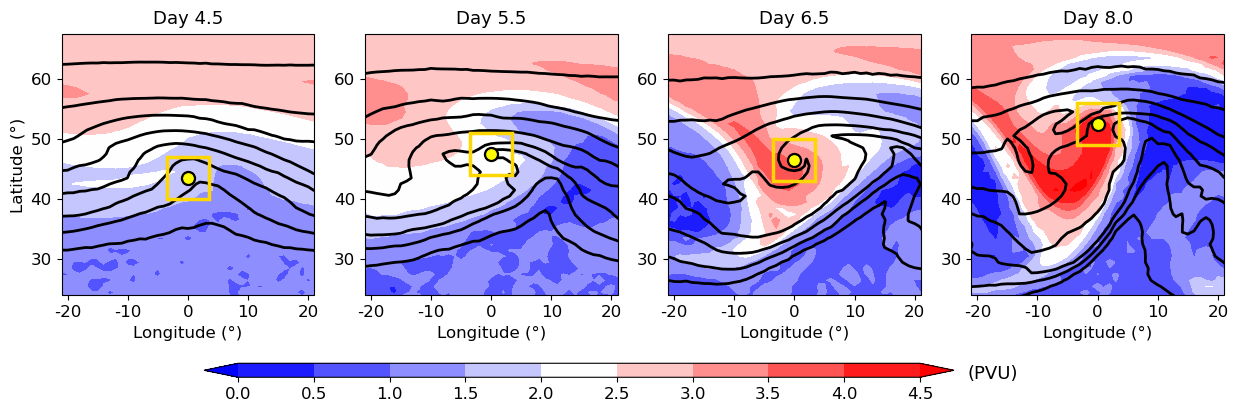

In [20]:
# Check the PTE results!

plt.rcParams['savefig.facecolor']='white'

lonmin=lons.min()+5
lonmax=lons.max()-4

latmin0=24
latmax0=66
latmin2=34
latmax2=63
latmin3=34
latmax3=63
# Showing Dp/dt term at a given time step
stp0 = 8   #4.5 day
stp1 = 12   #5.5 day
stp2 = 16 #5.25 day
stp3 = 22 # stp=17: 6.75 day 
#stp3 = 16 # stp=16: 6.5 day  
#stp3 = 20 # stp=16: 7.5 day  

#print('Simulation on day ',time[stp]+1)


lev1 = 9+10+5  #250 hPa
lev2 = 9+10+10+10+10 #500hPa
lev3 = 9+10+10+10+10+10+10+15 # 850 hPa
#lev = 9: 100hPa in our intepolated input data
ctv = 'k'
cmap = 'bwr'
clevsomg=np.arange(-150,210,30)
# --------------------------------------------

print (level[lev1]/100,' (hPa)')
print (level[lev2]/100,' (hPa)')
print (level[lev3]/100,' (hPa)')

tfact = (6/dt) # This is for an easier comparison between the 6-h vs 1-h results (converting to the same unit)
clevs_mslp=np.arange(906,1060,6)
clevs=np.arange(-6e-4,7e-4,1e-4)
clevs_Tv=np.arange(170,380,5)
#clevs_geop=np.arange(820,10720,80)
#clevs_geop=np.arange(820,10720,100)
clevs_geop=np.arange(930,10720,100)
clevs_pv = np.arange(0,5,0.5)
if exp == 'channel_'+res+'_0002':
    shift_lon=19
    shift_lon1=5
    shift_lon2=-13
    shift_lon3=18 
if exp == 'channel_'+res+'_0001':
    shift_lon=19
    shift_lon1=5
    shift_lon2=-10
    shift_lon3=21
if exp == 'channel_'+res+'_0003':
    shift_lon=19
    shift_lon1=5
    shift_lon2=-13
    shift_lon3=18 
if exp == 'channel_'+res+'_0004':
    if res=='2km':
        shift_lon=16
        shift_lon1=5
        shift_lon2=-20
        shift_lon3=10
    else:
        shift_lon=15
        shift_lon1=5
        shift_lon2=-20
        shift_lon3=-10
if exp == 'channel_'+res+'_0005':
    if res=='2km':
        shift_lon=15
        shift_lon1=5
        shift_lon2=20
        shift_lon3=-4
    else:
        shift_lon=15
        shift_lon1=5
        shift_lon2=-20
        shift_lon3=-10
if exp == 'channel_'+res+'_0006':
    if res=='2km':
        shift_lon=-20
        shift_lon1=12
        shift_lon2=5
        shift_lon3=-20
    else:
        shift_lon=-20
        shift_lon1=12
        shift_lon2=0
        shift_lon3=-20

for i in range(ntrack):
    #find timestep corresponding to track and data
    if track_dur[i] == time[stp0]  :
        cen_lon0=track_lon[i]+shift_lon
        cen_lat0=track_lat[i]
        print (cen_lon0-shift_lon,cen_lat0)
    if track_dur[i] == time[stp1]  :
        cen_lon1=track_lon[i]+shift_lon1
        cen_lat1=track_lat[i]
        print (cen_lon1-shift_lon,cen_lat1)
    if track_dur[i] == time[stp2]  :
        cen_lon2=track_lon[i]+shift_lon2
        cen_lat2=track_lat[i]
        print (cen_lon2-shift_lon2,cen_lat2)
    if track_dur[i] == time[stp3]  :
        cen_lon3=track_lon[i]+shift_lon3
        cen_lat3=track_lat[i]
        print (cen_lon3-shift_lon3,cen_lat3)

pv_avg_roll0=np.roll(pv_avg,shift_lon,axis=2)
mslp_roll0=np.roll(mslp,shift_lon,axis=2)
Tv_roll0=np.roll(T_v,shift_lon,axis=3)
#omega_roll0=np.roll(omega*100,shift_lon, axis=3)

pv_avg_roll1=np.roll(pv_avg,shift_lon1,axis=2)
mslp_roll1=np.roll(mslp,shift_lon1,axis=2)
Tv_roll1=np.roll(T_v,shift_lon1,axis=3)

pv_avg_roll2=np.roll(pv_avg,shift_lon2,axis=2)
mslp_roll2=np.roll(mslp,shift_lon2,axis=2)
Tv_roll2=np.roll(T_v,shift_lon2,axis=3)

pv_avg_roll3=np.roll(pv_avg,shift_lon3,axis=2)
mslp_roll3=np.roll(mslp,shift_lon3,axis=2)
Tv_roll3=np.roll(T_v,shift_lon3,axis=3)
#omega_roll3=np.roll(omega*100,shift_lon3, axis=3)


fig = plt.figure(figsize=(15,5))

            
ax1 = plt.subplot(1,4,1,projection=ccrs.PlateCarree())
ax1.set_extent([cen_lon0-21, cen_lon0+21, latmin0, latmax0])    
cd = plt.contourf(lons,lats,pv_avg_roll0[stp0,:,:]*1.e6,clevs_pv, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
cdc = plt.contour(lons,lats,Tv_roll0[stp0,lev3,:,:],clevs_Tv,colors='k',linewidths=2,transform=ccrs.PlateCarree())
#cs = plt.contour(lons,lats,mslp_roll0[stp,:,:]*0.01,clevs_mslp, linestyles='dotted',colors='k',linewidths=1.5
#                            ,transform=ccrs.PlateCarree())
#clabels = plt.clabel(cs, inline=True,fmt='%1.f', fontsize=10) 
#[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
           
ax1.set_yticks([30,40,50,60])
ax1.set_ylabel('Latitude (°)',fontsize=12)
ax1.set_yticklabels(['30','40','50','60'])
        
ax1.set_xticks([cen_lon0-20, cen_lon0-10,cen_lon0,cen_lon0+10,cen_lon0+20])
ax1.set_xlabel('Longitude (°)',fontsize=12)
ax1.set_xticklabels([-20,-10,0,10,20])
ax1.tick_params(axis='both', labelsize=12)

        #plt.scatter(cen_lon, cen_lat, c='k', s=80, zorder=25,transform=ccrs.PlateCarree())
plt.scatter(cen_lon0, cen_lat0, c='k', s=100, zorder=20)
plt.scatter(cen_lon0, cen_lat0, c='yellow', s=45, zorder=20)

boxsize = 7 # horizontal size of column in deg used for PTE analysis

ax1.add_patch(plt.Rectangle((cen_lon0-boxsize/2,
                                 cen_lat0-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 #ec='#1E62DE',
                                 ec='gold',
                                 ls='solid',
                                 linewidth=2.5,
                                 zorder=20,
                                 alpha=1))
      
              
xtxt = 0.5
ytxt = 1.04

ax1.text(xtxt, ytxt,'Day '+str(stp0*0.25+2.5),
         ha='center', fontsize=13,
         transform=ax1.transAxes, zorder=50)
#===============================================
            
ax1 = plt.subplot(1,4,2,projection=ccrs.PlateCarree())
ax1.set_extent([cen_lon1-21, cen_lon1+21, latmin0, latmax0])    
cd = plt.contourf(lons,lats,pv_avg_roll1[stp1,:,:]*1.e6,clevs_pv, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
cdc = plt.contour(lons,lats,Tv_roll1[stp1,lev3,:,:],clevs_Tv,colors='k',linewidths=2,transform=ccrs.PlateCarree())
#cs = plt.contour(lons,lats,mslp_roll0[stp,:,:]*0.01,clevs_mslp, linestyles='dotted',colors='k',linewidths=1.5
#                            ,transform=ccrs.PlateCarree())
#clabels = plt.clabel(cs, inline=True,fmt='%1.f', fontsize=10) 
#[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
           
ax1.set_yticks([30,40,50,60])
#ax1.set_ylabel('Latitude (°)',fontsize=12)
ax1.set_yticklabels(['30','40','50','60'])
        
ax1.set_xticks([cen_lon1-20, cen_lon1-10,cen_lon1,cen_lon1+10,cen_lon1+20])
ax1.set_xlabel('Longitude (°)',fontsize=12)
ax1.set_xticklabels([-20,-10,0,10,20])
ax1.tick_params(axis='both', labelsize=12)

        #plt.scatter(cen_lon, cen_lat, c='k', s=80, zorder=25,transform=ccrs.PlateCarree())
plt.scatter(cen_lon1, cen_lat1, c='k', s=100, zorder=20)
plt.scatter(cen_lon1, cen_lat1, c='yellow', s=45, zorder=20)

boxsize = 7 # horizontal size of column in deg used for PTE analysis

ax1.add_patch(plt.Rectangle((cen_lon1-boxsize/2,
                                 cen_lat1-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 #ec='#1E62DE',
                                 ec='gold',
                                 ls='solid',
                                 linewidth=2.5,
                                 zorder=20,
                                 alpha=1))
      
              
xtxt = 0.5
ytxt = 1.04

ax1.text(xtxt, ytxt,'Day '+str(stp1*0.25+2.5),
         ha='center', fontsize=13,
         transform=ax1.transAxes, zorder=50)
#===============================================
           
ax1 = plt.subplot(1,4,3,projection=ccrs.PlateCarree())
ax1.set_extent([cen_lon2-21, cen_lon2+21, latmin0, latmax0])    
cd = plt.contourf(lons,lats,pv_avg_roll2[stp2,:,:]*1.e6,clevs_pv, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
cdc = plt.contour(lons,lats,Tv_roll2[stp2,lev3,:,:],clevs_Tv,colors='k',linewidths=2,transform=ccrs.PlateCarree())
#cs = plt.contour(lons,lats,mslp_roll2[stp2,:,:]*0.01,clevs_mslp, linestyles='dotted',colors='k',linewidths=1.5
#                            ,transform=ccrs.PlateCarree())
#clabels = plt.clabel(cs, inline=True,fmt='%1.f', fontsize=10) 
#[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
           
ax1.set_yticks([30,40,50,60])
#ax1.set_ylabel('Latitude (°)',fontsize=12)
ax1.set_yticklabels(['30','40','50','60'])

ax1.set_xticks([cen_lon2-20, cen_lon2-10,cen_lon2,cen_lon2+10,cen_lon2+20])
ax1.set_xlabel('Longitude (°)',fontsize=12)
ax1.set_xticklabels([-20,-10,0,10,20])
ax1.tick_params(axis='both', labelsize=12)
        #plt.scatter(cen_lon, cen_lat, c='k', s=80, zorder=25,transform=ccrs.PlateCarree())
plt.scatter(cen_lon2, cen_lat2, c='k', s=100, zorder=20)
plt.scatter(cen_lon2, cen_lat2, c='yellow', s=45, zorder=20)

boxsize = 7 # horizontal size of column in deg used for PTE analysis

ax1.add_patch(plt.Rectangle((cen_lon2-boxsize/2,
                                 cen_lat2-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 #ec='#1E62DE',
                                 ec='gold',
                                 ls='solid',
                                 linewidth=2.5,
                                 zorder=20,
                                 alpha=1))
      
              
xtxt = 0.5
ytxt = 1.04

ax1.text(xtxt, ytxt,'Day '+str(stp2*0.25+2.5),
         ha='center', fontsize=13,
         transform=ax1.transAxes, zorder=50)            
#===============================================
           
ax1 = plt.subplot(1,4,4,projection=ccrs.PlateCarree())
ax1.set_extent([cen_lon3-21, cen_lon3+21, latmin0, latmax0])    
cd = plt.contourf(lons,lats,pv_avg_roll3[stp3,:,:]*1.e6,clevs_pv, cmap=cmap,extend='both',transform=ccrs.PlateCarree())
cdc = plt.contour(lons,lats,Tv_roll3[stp3,lev3,:,:],clevs_Tv,colors='k',linewidths=2,transform=ccrs.PlateCarree())
#cs = plt.contour(lons,lats,mslp_roll3[stp3,:,:]*0.01,clevs_mslp, linestyles='dotted',colors='k',linewidths=1.5
#                            ,transform=ccrs.PlateCarree())
#clabels = plt.clabel(cs, inline=True,fmt='%1.f', fontsize=10) 
#[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
           
ax1.set_yticks([30,40,50,60])
#ax1.set_ylabel('Latitude (°)',fontsize=12)
ax1.set_yticklabels(['30','40','50','60'])
        
ax1.set_xticks([cen_lon3-20, cen_lon3-10,cen_lon3,cen_lon3+10,cen_lon3+20])
ax1.set_xlabel('Longitude (°)',fontsize=12)
ax1.set_xticklabels([-20,-10,0,10,20])
ax1.tick_params(axis='both', labelsize=12)

        #plt.scatter(cen_lon, cen_lat, c='k', s=80, zorder=25,transform=ccrs.PlateCarree())
plt.scatter(cen_lon3, cen_lat3, c='k', s=100, zorder=20)
plt.scatter(cen_lon3, cen_lat3, c='yellow', s=45, zorder=20)

boxsize = 7 # horizontal size of column in deg used for PTE analysis

ax1.add_patch(plt.Rectangle((cen_lon3-boxsize/2,
                                 cen_lat3-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 #ec='#1E62DE',
                                 ec='gold',
                                 ls='solid',
                                 linewidth=2.5,
                                 zorder=20,
                                 alpha=1))
      
              
xtxt = 0.5
ytxt = 1.04

ax1.text(xtxt, ytxt,'Day '+str(stp3*0.25+2.5),
         ha='center', fontsize=13,
         transform=ax1.transAxes, zorder=50)
#===============================================

fig.subplots_adjust(wspace = 0.2, hspace = 0.03)
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.22, 0.04, 0.5, 0.028]) # left,bottom,width,height
clb = plt.colorbar(cd,
                cax=cbar_ax,
                shrink=0.8,
                orientation='horizontal',
                extend='max')
        
        
#cb = fig.colorbar(cd, cax=cbar_ax, orientation='horizontal', extend='max')
tick_font_size = 12
clb.ax.tick_params(labelsize=tick_font_size)
clb.ax.set_title('(PVU)', fontsize=13, x=1.07, y=-0.1, ha='left',
             transform=clb.ax.transAxes)
#fig1.suptitle('Tadv (shaded) & mslp (contours) on Day '+str(time[stp])+'\n'+exp+'',fontsize=14, weight='bold')
#plt.title('Day 6.5')
#if exp == 'channel_80km_0001':
#    plt.savefig('FigR7_Tadv_diab_'+exp+'_Day4p5&6p5.png', bbox_inches='tight',dpi=100)
#else: 
plt.savefig('Upperlevel_PV_'+exp+'_Day4p5&5p5&6p5&8.png', bbox_inches='tight',dpi=150)
plt.show()